# Dataset Generation for Scattering from Multi-Layered Metamaterials

This program calculates and plots refraction and transmission coefficients of multi-layered structures as a function of frequency for a specific angle of incidence.

This code is adapted from the MATLAB code in Umit Cotuk's thesis "Scattering from multi-layered metamaterials using wave matrices", as found at http://hdl.handle.net/10945/2115.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange

In [9]:
def calc_response(f, theta, p, Mu, Ei, l, Sigma):
    """
    Calculate the transmission and reflection response of a structure with the given properties.

    Parameters
    ----------
    f: ndarray(shape=(M,), dtype=float)
        frequency range (GHz)
    theta: float
        Incidence angle (degrees)
    p: Union[Literal[0], Literal[1]]
        Polarization type - parallel (1) or perpendicular (2)
    Mu: ndarray(shape=(N, 1), dtype=float)
        permability (μ) for each layer
    Ei: ndarray(shape=(N, 1), dtype=float)
        permittivity (ɛ) for each layer
    l: ndarray(shape=(N, 1), dtype=float)
        length of each layer (meters)
    Sigma: ndarray(shape=(N, 1), dtype=float)
        material's loss for each layer

    Returns
    -------
    tuple[ndarray(shape=(M,), dtype=complex), ndarray(shape=(M,), dtype=complex)]
        transmission response, reflection response
    """
    E0 = 8.85e-12         # Permittivity of free space
    Mu0 = 12.5664e-7      # Permeability of free space
    c = 1/np.sqrt(E0*Mu0) # Speed of light (m/s)

    N = len(Mu) # number of layers
    thr = theta*np.pi/180 # Angle of incidence (radians)
    st = math.sin(thr)
    ct = math.cos(thr)

    reflection = []
    transmission = []

    E = np.abs(Ei)

    rho = np.zeros_like(Ei, dtype=complex)
    tau = np.zeros_like(Ei, dtype=complex)
    w = np.zeros_like(f, dtype=complex)

    # This part calculates the total reflection and transmission coefficients of the structure
    for i in range(len(f)):
        wl = c/(f[i]*1e9)
        beta1 = 2*(np.pi/wl)
        total = np.array([[1,0], [0,1]], dtype=complex)
        w[i] = 2*np.pi*f[i]*1e9

        # Calculating the characteristic impedance of the layers
        Er = np.zeros_like(E, dtype=complex)
        Z = np.zeros_like(E, dtype=complex)
        for k in range(N):
            Er[k] = E[k] - (1j * Sigma[k]/w[i]/E0)

            if p == 1:
                Z[k] = np.sqrt(Er[k] * Mu[k]-st**2)/Er[k]/ct
            elif p == 2:
                Z[k] = Mu[k] * ct/np.sqrt(Er[k] * Mu[k]-st**2)

        # Individual reflection and transmission coefficients of the layers
        rho[0] = (Z[0] - 1)/(Z[0] + 1)
        tau[0] = rho[0] + 1

        for m in range(1, N):
            rho[m] = (Z[m]-Z[m-1])/(Z[m]+Z[m-1])
            tau[m] = rho[m] + 1

        # Generating wave matrices
        for n in range(N-1):
            sign = -1 if Ei[n] < 0 else 1
            beta = beta1*sign
            A = np.exp(1j*beta*l[n]*np.sqrt(Er[n]-st**2))
            Ac = np.exp(-1j*beta*l[n]*np.sqrt(Er[n]-st**2))
            total = np.matmul(total, np.squeeze(np.array([[A, rho[n]*Ac],[rho[n]*A, Ac]])), dtype=complex)/tau[n]

        total = np.matmul(total, np.array([[1, rho[N-1][0]], [rho[N-1][0], 1]]))/tau[N-1]
        reflection.append(total[1,0]/total[0,0])
        transmission.append(1/total[0,0])

    transmission_response = np.abs(np.array(transmission, dtype=complex))
    reflection_response = np.abs(np.array(reflection, dtype=complex))
    return transmission_response, reflection_response

## Define dataset parameters

In [12]:
# Material property constants
epsilon_SiO2 = 1.46
epsilon_SiN3 = 3.1
epsilon_TiO2 = 5.913

# Define dataset parameters
fileName = 'SiO2_TiO2_6layer'  # Dataset file name

NDataPoints = 20000            # Number of structures to generate
NSamp = 201                    # Number of samples in the response

fmin = 450e3                   # min frequency in GHz (ex. 450e3 -> 450 THz)
fmax = 750e3                   # max frequency in GHz
f = np.linspace(fmin, fmax, NSamp)   # frequency range

p = 1                          # p = Polarization Type Parallel (1), Perpendicular (2)
theta = 0                      # theta = Incidence Angle (Degree)

# Define structure properties
N = 6                          # num layers

# lmin = 100e-9                # Min layer height (m)
# lmax = 160e-9                # Max layer height (m)
# Function to create a device with random design parameters
make_rand_layers = lambda: np.random.randint(100, 160, (N,))*1e-9

epsilon_1 = epsilon_SiO2       # First material's permittivity (ɛ)
epsilon_2 = epsilon_TiO2       # Second material's permittivity (ɛ)

Mu_1 = 1                       # First material's permeability (μ)
Mu_2 = 1                       # Second material's permeability (μ)

sigma_1 = 0                    # First material's loss (sigma)
sigma_2 = 0                    # Second material's loss (sigma)

# Define Mu, Ei, Sigma by alternating the two materials
Mu = np.empty((N, 1))
Ei = np.empty((N, 1))
sigma = np.empty((N, 1))

for i in range(N):
    if i%2 == 0:
        Mu[i] = Mu_1
        Ei[i] = epsilon_1
        sigma[i] = sigma_1
    
    else:
        Mu[i] = Mu_2
        Ei[i] = epsilon_2
        sigma[i] = sigma_2

[1.53e-07 1.23e-07 1.02e-07 1.50e-07 1.48e-07 1.09e-07]


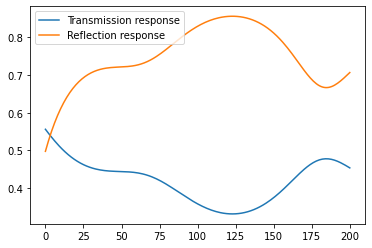

In [20]:
# As an example, plot transmission and reflectance response from a randomly generated device
layers = make_rand_layers()
print(layers)
trans_resp, refl_resp = calc_response(f, theta, p, Mu, Ei, layers, sigma)
plt.plot(trans_resp, label='Transmission response')
plt.plot(refl_resp, label='Reflection response')
plt.legend(loc='upper left')

## Create dataset

In [21]:
transmission_responses = np.zeros((NSamp, NDataPoints))
reflection_responses = np.zeros((NSamp, NDataPoints))
device_layers = np.zeros((N, NDataPoints))

for device_num in trange(NDataPoints):
    layers = make_rand_layers()
    trans_resp, refl_resp = calc_response(f, theta, p, Mu, Ei, layers, sigma)
    transmission_responses[:, device_num] = trans_resp
    reflection_responses[:, device_num] = refl_resp
    device_layers[:, device_num] = layers

# Create CSV for transmission responses, where each device's response is one column
np.savetxt(fileName + '_RS_transmission.csv', transmission_responses, delimiter=',')

# Create CSV for reflection responses, where each device's response is one column
np.savetxt(fileName + '_RS_reflection.csv', reflection_responses, delimiter=',')

# Create CSV for design parameters, where each device's design is one column
np.savetxt(fileName + '_DS.csv', device_layers, delimiter=',')


100%|██████████| 20000/20000 [14:43<00:00, 22.64it/s]
